In [1]:
import pandas as pd
import csv
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import itertools
import csv
import string
import pickle
import matplotlib.pyplot as plt

from collections import Counter
import re
import spacy
import nltk
from spacy.lang.en import English
from nltk.util import ngrams
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

[nltk_data] Downloading package wordnet to /Users/xzhou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/xzhou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
file_url = '/Users/xzhou/github/project_archives/files_airbnb/{}.csv'

sf_file = file_url.format('sf_airbnb/reviews')
ok_file = file_url.format('ok_airbnb/reviews')
sc_file = file_url.format('sc_airbnb/reviews')
scz_file = file_url.format('scz_airbnb/reviews')

In [3]:
reviews_sf = pd.read_csv(sf_file)
reviews_ok = pd.read_csv(ok_file)
reviews_sc = pd.read_csv(sc_file)
reviews_scz = pd.read_csv(scz_file)

In [4]:
print (reviews_sf.shape, reviews_ok.shape, reviews_sc.shape, reviews_scz.shape)

(278884, 6) (78491, 6) (135238, 6) (76086, 6)


In [5]:
frames = [reviews_sf, reviews_ok, reviews_sc, reviews_scz]
keys = ['reviews_sf', 'reviews_ok', 'reviews_sc', 'reviews_scz']

In [6]:
df_reviews = pd.concat(frames, keys=keys)
df_reviews.head(10)

listing_id       id        date  reviewer_id reviewer_name  \
reviews_sf 0         958     5977  2009-07-23        15695      Edmund C   
           1         958     6660  2009-08-03        26145         Simon   
           2         958    11519  2009-09-27        25839         Denis   
           3         958    16282  2009-11-05        33750          Anna   
           4         958    26008  2010-02-13        15416       Venetia   
           5         958    29240  2010-03-13        78623       Mathieu   
           6         958    32988  2010-04-03        96027        Lauren   
           7         958   220443  2011-04-08       426888      Michelle   
           8         958   567690  2011-09-26       539189         Sarah   
           9         958  1786860  2012-07-24      2059845          Jörg   

                                                       comments  
reviews_sf 0  Our experience was, without a doubt, a five st...  
           1  Returning to San Francisco is a rejuvenating t...  
           2  We were very pleased with the accommodations a...  
           3  We highly recommend this accomodation and agre...  
           4  Holly's place was great. It was exactly what I...  
           5  On top of all that has been said previously, I...  
           6  This apartment was everything I could have hop...  
           7  Great place to stay.  I would highly recommend...  
           8  Great location in San Francisco, really felt l...  
           9  We had a wonderful time at Holly & Davids plac...

In [7]:
df_reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [8]:
columns_to_drop=['id', 'date', 'reviewer_id', 'reviewer_name']

In [9]:
df_reviews.drop(columns_to_drop, axis=1, inplace=True)

In [10]:
# Drop Null values in reviews

df_reviews.dropna(inplace=True)

In [11]:
df_reviews.shape

(568165, 2)

In [12]:
# Pull the final datasets. This is to narrow down the dataset to focus on

pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'

pkl_path = pkl_file.format('listings_seasonality')

df_listings_seasonality = pd.read_pickle(pkl_path)
df_listings_seasonality.head()

,listing_id,price_by_month_week,Apr.,Aug.,Dec.,Feb.,Jan.,Jul.,Jun.,Mar.,...,neighbourhood_cleansed_Palo Alto,host_is_superhost_f,amenities_Lock on bedroom door,amenities_Private entrance,amenities_Familykid friendly,district_Santa Clara,neighbourhood_cleansed_San Jose,host_identity_verified_f,ref_district,ref_jurisdiction
0,5858,235.0,0,0,0,0,1,0,0,0,...,0,1,0,1,1,0,0,0,San Francisco,SAN FRANCISCO
1,5858,235.0,0,0,0,0,1,0,0,0,...,0,1,0,1,1,0,0,0,San Francisco,SAN FRANCISCO
2,5858,235.0,0,0,0,0,1,0,0,0,...,0,1,0,1,1,0,0,0,San Francisco,SAN FRANCISCO
3,5858,235.0,0,0,0,0,1,0,0,0,...,0,1,0,1,1,0,0,0,San Francisco,SAN FRANCISCO
4,5858,235.0,0,0,0,0,1,0,0,0,...,0,1,0,1,1,0,0,0,San Francisco,SAN FRANCISCO


In [13]:
df_listings_seasonality.shape

(245629, 53)

In [14]:
# Get a list of unique IDs. This is to narrow down reviews that need to analyze

listing_id_interested = df_listings_seasonality.listing_id.unique()
len(listing_id_interested)

3006

In [15]:
# Filter to smaller datasets for analysis

df_reviews = df_reviews[df_reviews['listing_id'].isin(listing_id_interested)]

In [16]:
df_reviews.shape

(169066, 2)

In [17]:
pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'

pkl_path = pkl_file.format('listings_with_selected_features')

df_listings = pd.read_pickle(pkl_path)
df_listings.head()

,id,bedrooms,cleaning_fee,room_type_Entire home/apt,reviews_per_month,city_San Francisco,city_Oakland,bathrooms,accommodates,number_of_reviews,...,neighbourhood_cleansed_Palo Alto,host_is_superhost_f,amenities_Lock on bedroom door,amenities_Private entrance,amenities_Familykid friendly,district_Santa Clara,neighbourhood_cleansed_San Jose,host_identity_verified_f,ref_district,ref_jurisdiction
0,958,1.0,2.00000,1,1.38,1,0,1.0,3,152,...,0,0,0,1,1,0,0,0,San Francisco,SAN FRANCISCO
1,5858,2.0,2.00000,1,0.99,1,0,1.0,5,112,...,0,1,0,1,1,0,0,0,San Francisco,SAN FRANCISCO
2,7918,1.0,1.69897,0,0.16,1,0,4.0,2,17,...,0,1,1,1,0,0,0,0,San Francisco,SAN FRANCISCO
3,8142,1.0,1.69897,0,0.15,1,0,4.0,2,7,...,0,1,1,1,1,0,0,0,San Francisco,SAN FRANCISCO
4,8567,2.0,2.09691,1,0.27,1,0,1.0,6,30,...,0,1,0,0,1,0,0,1,San Francisco,SAN FRANCISCO


In [18]:
df_listings_reviews = pd.merge(left = df_reviews, 
                               right = df_listings,
                               how = 'inner',
                               left_on='listing_id', 
                               right_on='id')
df_listings_reviews.head()

,listing_id,comments,id,bedrooms,cleaning_fee,room_type_Entire home/apt,reviews_per_month,city_San Francisco,city_Oakland,bathrooms,...,neighbourhood_cleansed_Palo Alto,host_is_superhost_f,amenities_Lock on bedroom door,amenities_Private entrance,amenities_Familykid friendly,district_Santa Clara,neighbourhood_cleansed_San Jose,host_identity_verified_f,ref_district,ref_jurisdiction
0,5858,We had a fabulous time staying with Philip and...,5858,2.0,2.0,1,0.99,1,0,1.0,...,0,1,0,1,1,0,0,0,San Francisco,SAN FRANCISCO
1,5858,Great place to stay in SF. Tania and Philip we...,5858,2.0,2.0,1,0.99,1,0,1.0,...,0,1,0,1,1,0,0,0,San Francisco,SAN FRANCISCO
2,5858,We had an excellent stay. We loved the neighbo...,5858,2.0,2.0,1,0.99,1,0,1.0,...,0,1,0,1,1,0,0,0,San Francisco,SAN FRANCISCO
3,5858,Tania and Philip are wonderful and cheerful - ...,5858,2.0,2.0,1,0.99,1,0,1.0,...,0,1,0,1,1,0,0,0,San Francisco,SAN FRANCISCO
4,5858,We enjoyed the great location and peaceful int...,5858,2.0,2.0,1,0.99,1,0,1.0,...,0,1,0,1,1,0,0,0,San Francisco,SAN FRANCISCO


In [19]:
df_listings_reviews.drop(['id'], axis=1, inplace=True)

In [20]:
df_listings_reviews.dropna(inplace=True)

In [21]:
# Drop any possible duplicate lines before saving the result

df_listings_reviews = df_listings_reviews.drop_duplicates()
df_listings_reviews.shape

(169007, 34)

In [22]:
pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'

pkl_path = pkl_file.format('listings_reviews')

pd.to_pickle(df_listings_reviews, pkl_path)

In [23]:
# Filter to smaller subset of data. Goal is to understand the main topics within each sentiment

df_smaller = df_listings_reviews.loc[:, ['listing_id', 'review_scores_rating_log10', 'comments']]
df_smaller.head()

,listing_id,review_scores_rating_log10,comments
0,5858,1.991226,We had a fabulous time staying with Philip and...
1,5858,1.991226,Great place to stay in SF. Tania and Philip we...
2,5858,1.991226,We had an excellent stay. We loved the neighbo...
3,5858,1.991226,Tania and Philip are wonderful and cheerful - ...
4,5858,1.991226,We enjoyed the great location and peaceful int...


In [24]:
def sentiment(x):
    """
    This is to assignment sentiment based on rating scores.
    Since ratings score has been taken log10, thus needs to apply
    this on cutoff values as well
    """
    if x>np.log10(50) and x<np.log10(60):
        return 'neutral'
    if x>=np.log10(60):
        return 'positive'
    if x<=np.log10(50):
        return 'negative'

In [25]:
def sentiment_score(x):
    """
    This is to assign numerical value to each sentiment category.
    """
    if x == 'neutral':
        return 0
    elif x == 'positive':
        return 1
    elif x == 'negative':
        return (-1)
    else:
        return 'error'

In [26]:
df_smaller['sentiment'] = df_smaller.review_scores_rating_log10.apply(lambda x: sentiment(x))

In [27]:
df_smaller['sentiment_score'] = df_smaller.sentiment.apply(lambda x: sentiment_score(x))

In [28]:
df_smaller.head()

,listing_id,review_scores_rating_log10,comments,sentiment,sentiment_score
0,5858,1.991226,We had a fabulous time staying with Philip and...,positive,1
1,5858,1.991226,Great place to stay in SF. Tania and Philip we...,positive,1
2,5858,1.991226,We had an excellent stay. We loved the neighbo...,positive,1
3,5858,1.991226,Tania and Philip are wonderful and cheerful - ...,positive,1
4,5858,1.991226,We enjoyed the great location and peaceful int...,positive,1


In [29]:
df_pos = df_smaller[df_smaller['sentiment_score']==1]
df_neg = df_smaller[df_smaller['sentiment_score']==-1]
print(df_pos.shape, df_neg.shape)

(168947, 5) (49, 5)


In [30]:
df_smaller.describe (include='all')

,listing_id,review_scores_rating_log10,comments,sentiment,sentiment_score
count,1.690070e+05,169007.000000,169007,169007,169007.000000
unique,NaN,NaN,166635,3,NaN
top,NaN,NaN,Great place!,positive,NaN
freq,NaN,NaN,95,168947,NaN
mean,6.610332e+06,1.979938,NaN,NaN,0.999355
std,6.330910e+06,0.030009,NaN,NaN,0.034991
min,5.858000e+03,0.000000,NaN,NaN,-1.000000
25%,1.264430e+06,1.973128,NaN,NaN,1.000000
50%,4.607282e+06,1.986772,NaN,NaN,1.000000
75%,1.023532e+07,1.991226,NaN,NaN,1.000000


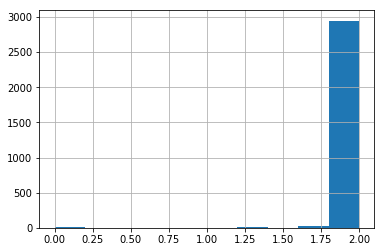

In [31]:
# Get an understanding of rating distribution. It seems majority of ratings are very positive
# The data wouldn't be helpful to understand customers' negatie sentiment

df_smaller.groupby(by='listing_id').review_scores_rating_log10.first().hist()

In [32]:
# # File after comparing listings and seasonality. 
# # Because there are too many reviews to process, 
# # this is to help narrow down number of reviews to analyze

# pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'
# pkl_path = pkl_file.format('listings_seasonality')

# try: 
#     with open(pkl_path, 'rb') as file:
#         df_listings_seasonality = pd.read_pickle(file)
# except:
#     with open(pkl_path, 'wb') as file:
#         pd.to_pickle(df_final, file)

In [33]:
# # Get a list of unique IDs. This is to narrow down reviews that need to analyze

# listing_id_interested = df_listings_seasonality.listing_id.unique()

In [34]:
# len(listing_id_interested)

In [35]:
# df_smaller = df_smaller[df_smaller['id'].isin(listing_id_interested)]

In [36]:
df_smaller.shape

(169007, 5)

In [37]:
# Break down reviews by word. 
# Goal is to remove reviews that don't have meaningful length

df_smaller['comments_words_ind_review'] = df_smaller['comments'].apply(nltk.word_tokenize)

In [38]:
# Perform a word count for each review. 
# This is to remove reviews that don't have meaningful leangh

df_smaller['word_count_ind_review'] = df_smaller['comments_words_ind_review'].apply(len)
df_smaller.head()

,listing_id,review_scores_rating_log10,comments,sentiment,sentiment_score,comments_words_ind_review,word_count_ind_review
0,5858,1.991226,We had a fabulous time staying with Philip and...,positive,1,"[We, had, a, fabulous, time, staying, with, Ph...",91
1,5858,1.991226,Great place to stay in SF. Tania and Philip we...,positive,1,"[Great, place, to, stay, in, SF, ., Tania, and...",67
2,5858,1.991226,We had an excellent stay. We loved the neighbo...,positive,1,"[We, had, an, excellent, stay, ., We, loved, t...",54
3,5858,1.991226,Tania and Philip are wonderful and cheerful - ...,positive,1,"[Tania, and, Philip, are, wonderful, and, chee...",72
4,5858,1.991226,We enjoyed the great location and peaceful int...,positive,1,"[We, enjoyed, the, great, location, and, peace...",29


In [39]:
df_smaller.shape

(169007, 7)

In [40]:
# Keep only comments that have meaningful length

df_smaller = df_smaller[df_smaller['word_count_ind_review']>=10]
df_smaller.shape

(156129, 7)

In [41]:
# Concolidate all reviews belong to a single 'id' to one big comment. 
# This for easier processing later on

df_consolicated_reviews = df_smaller.groupby('listing_id').comments.apply(lambda x: ' ,'.join(x)).reset_index()

In [42]:
df_consolicated_reviews.head()

,listing_id,comments
0,5858,We had a fabulous time staying with Philip and...
1,7918,My stay was fantastic! The neighborhood is gr...
2,8142,"Excellent! The space is clean and quiet, and t..."
3,9225,"Wow, what a treat to stay in a place where eve..."
4,10251,we had a great experience. sarah and ramon wer...


In [43]:
df_consolicated_reviews.shape

(2951, 2)

In [44]:
df_final = pd.merge(left = df_smaller, 
                    right = df_consolicated_reviews, 
                    how='left', 
                    left_on ='listing_id', 
                    right_on = 'listing_id')

In [45]:
df_final.shape

(156129, 8)

In [46]:
df_final.head()

,listing_id,review_scores_rating_log10,comments_x,sentiment,sentiment_score,comments_words_ind_review,word_count_ind_review,comments_y
0,5858,1.991226,We had a fabulous time staying with Philip and...,positive,1,"[We, had, a, fabulous, time, staying, with, Ph...",91,We had a fabulous time staying with Philip and...
1,5858,1.991226,Great place to stay in SF. Tania and Philip we...,positive,1,"[Great, place, to, stay, in, SF, ., Tania, and...",67,We had a fabulous time staying with Philip and...
2,5858,1.991226,We had an excellent stay. We loved the neighbo...,positive,1,"[We, had, an, excellent, stay, ., We, loved, t...",54,We had a fabulous time staying with Philip and...
3,5858,1.991226,Tania and Philip are wonderful and cheerful - ...,positive,1,"[Tania, and, Philip, are, wonderful, and, chee...",72,We had a fabulous time staying with Philip and...
4,5858,1.991226,We enjoyed the great location and peaceful int...,positive,1,"[We, enjoyed, the, great, location, and, peace...",29,We had a fabulous time staying with Philip and...


In [47]:
# Since we have consolidated reviews. Only keep one consolidated review per Listing ID

df_final.drop_duplicates(subset=['comments_y'], keep='first', inplace=True)

In [49]:
df_final.head(10)

,listing_id,review_scores_rating_log10,comments_x,sentiment,sentiment_score,comments_words_ind_review,word_count_ind_review,comments_y
0,5858,1.991226,We had a fabulous time staying with Philip and...,positive,1,"[We, had, a, fabulous, time, staying, with, Ph...",91,We had a fabulous time staying with Philip and...
110,7918,1.929419,My stay was fantastic! The neighborhood is gr...,positive,1,"[My, stay, was, fantastic, !, The, neighborhoo...",23,My stay was fantastic! The neighborhood is gr...
126,8142,1.959041,"Excellent! The space is clean and quiet, and t...",positive,1,"[Excellent, !, The, space, is, clean, and, qui...",28,"Excellent! The space is clean and quiet, and t..."
133,9225,1.968483,"Wow, what a treat to stay in a place where eve...",positive,1,"[Wow, ,, what, a, treat, to, stay, in, a, plac...",137,"Wow, what a treat to stay in a place where eve..."
525,10251,1.977724,we had a great experience. sarah and ramon wer...,positive,1,"[we, had, a, great, experience, ., sarah, and,...",37,we had a great experience. sarah and ramon wer...
803,10832,1.963788,This beautiful loft comfortably slept the 3 of...,positive,1,"[This, beautiful, loft, comfortably, slept, th...",37,This beautiful loft comfortably slept the 3 of...
819,12042,1.806180,Aaron was a great host during my month in San ...,positive,1,"[Aaron, was, a, great, host, during, my, month...",63,Aaron was a great host during my month in San ...
824,12584,1.968483,The house has an amazing view... really lovely...,positive,1,"[The, house, has, an, amazing, view, ..., real...",91,The house has an amazing view... really lovely...
838,14125,1.991226,Olivia provided a very warm experience for our...,positive,1,"[Olivia, provided, a, very, warm, experience, ...",54,Olivia provided a very warm experience for our...
927,21914,1.892095,I was happy with my stay at Aaron's place !!! ...,positive,1,"[I, was, happy, with, my, stay, at, Aaron, 's,...",86,I was happy with my stay at Aaron's place !!! ...


In [50]:
# Drop un-used columns. 'Comments-words' need to be dropped, as this is
# for individual review, not consolidated review.

columns_to_drop = ['comments_x', 'comments_words_ind_review', 'word_count_ind_review']
df_final.drop (columns_to_drop, axis=1, inplace=True)
df_final.head()

,listing_id,review_scores_rating_log10,sentiment,sentiment_score,comments_y
0,5858,1.991226,positive,1,We had a fabulous time staying with Philip and...
110,7918,1.929419,positive,1,My stay was fantastic! The neighborhood is gr...
126,8142,1.959041,positive,1,"Excellent! The space is clean and quiet, and t..."
133,9225,1.968483,positive,1,"Wow, what a treat to stay in a place where eve..."
525,10251,1.977724,positive,1,we had a great experience. sarah and ramon wer...


In [51]:
df_final.rename( index=str, columns ={'comments_y': 'reviews_consol'}, inplace=True)
df_final.head()

,listing_id,review_scores_rating_log10,sentiment,sentiment_score,reviews_consol
0,5858,1.991226,positive,1,We had a fabulous time staying with Philip and...
110,7918,1.929419,positive,1,My stay was fantastic! The neighborhood is gr...
126,8142,1.959041,positive,1,"Excellent! The space is clean and quiet, and t..."
133,9225,1.968483,positive,1,"Wow, what a treat to stay in a place where eve..."
525,10251,1.977724,positive,1,we had a great experience. sarah and ramon wer...


In [52]:
# Break down consolidated reviews by word. 

df_final['review_words_consol'] = df_final['reviews_consol'].apply(nltk.word_tokenize)

In [53]:
# Perform a word count for each review. 
# This is to remove reviews that don't have meaningful leangh

df_final['word_count_consol'] = df_final['review_words_consol'].apply(len)
df_final.head()

,listing_id,review_scores_rating_log10,sentiment,sentiment_score,reviews_consol,review_words_consol,word_count_consol
0,5858,1.991226,positive,1,We had a fabulous time staying with Philip and...,"[We, had, a, fabulous, time, staying, with, Ph...",7467
110,7918,1.929419,positive,1,My stay was fantastic! The neighborhood is gr...,"[My, stay, was, fantastic, !, The, neighborhoo...",1115
126,8142,1.959041,positive,1,"Excellent! The space is clean and quiet, and t...","[Excellent, !, The, space, is, clean, and, qui...",354
133,9225,1.968483,positive,1,"Wow, what a treat to stay in a place where eve...","[Wow, ,, what, a, treat, to, stay, in, a, plac...",29838
525,10251,1.977724,positive,1,we had a great experience. sarah and ramon wer...,"[we, had, a, great, experience, ., sarah, and,...",20379


In [54]:
pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'
pkl_path = pkl_file.format('reviews_final')

try: 
    with open(pkl_path, 'rb') as file:
        df_final = pd.read_pickle(file)
except:
    with open(pkl_path, 'wb') as file:
        pd.to_pickle(df_final, file)

In [55]:
X = df_final['reviews_consol']

In [57]:
# Define a topic modeling engine for intensive modeling. 
# This can help test out models and identify optimal result.

class TopicModelEngine:
    
    def __init__(self, raw_data):
        self.raw_data = raw_data

    def get_lemma(self, word):
        """
        Get the root words
        """
        try:
            lemma = wn.morphy(word)
        except:
            lemma = word
        return lemma
            
    def tokenize(self, text):
        """
        This is to perform word tokenizing. It performs ngram (1,2)
        """
        lda_tokens = []
        text=text.strip().lower()

        # Extract word portion out of sentence and excludes spaace
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(text)
        tokens = [token for token in tokens if (not token.isspace())]

        for token in tokens:
            lda_tokens.append(token)

        # Extract bigrams for additional analysis
        bigrams = ngrams(tokens, 2)

        for bg, count in Counter(bigrams).most_common():
            token_string = []
            token_string = str(bg[0]) + " " + str(bg[1])
            lda_tokens.append(token_string)

        return lda_tokens
    
    def text_processing(self, sentence, stop_words):
        """
        This is to break down text sentence into words, and 
        clean up the words to prepare for LDA modeling.
        """
    
        tokens = self.tokenize(sentence)
        tokens = [word for word in tokens if len(tokens)>5]
        tokens = [word for word in tokens if word.strip() not in stop_words]
        tokens = [self.get_lemma(word) for word in tokens]

        return tokens 
    
    def LDA_preprocessing(self, stop_words):
        """
        Provided with raw data, the proprocessing will automatically prepare and
        clean up the data, and generate necessay documents for LDA's use.
        """
        self.text_data = []

        for line in self.raw_data:
            tokens = self.text_processing(line, stop_words)
            tokens=[token for token in tokens if token is not None]
            self.text_data.append(tokens)
        
        # Create Dictionary
        self.dictionary = corpora.Dictionary(self.text_data)
        # Term Document Frequency
        self.corpus = [self.dictionary.doc2bow(text) for text in self.text_data]

    def LDA_model(self, num_of_topics, num_passes, stop_words):
        """
        This is to perform topic modeling and save the model under the name
        user provides
        """
        self.LDA_preprocessing(stop_words)
        num_topics = num_of_topics
        self.lda = LdaModel(corpus=self.corpus,  
                            num_topics=num_topics, 
                            id2word=self.dictionary, 
                            passes=num_passes) 
        
        #self.lda_corpus = self.lda(self.corpus)
        
        #self.lda.save(file_name_to_save_as)
        
        return self.lda
    
    def print_topics(self, num_of_words):
        """
        Print out topics for users's decision making. 
        User can specify number of words to print out
        """
        topics = self.lda.print_topics(num_words=num_of_words)
        for topic in topics:
            print('Topic ' + str(topic[0]+1)+': '+str(topic[1]))
            
    def word_cloud(self, num_of_topics):
        for topic in range(num_of_topics):
            plt.figure(figsize=(14,8))
            plt.imshow(WordCloud().fit_words(dict(self.lda.show_topic(topic, 200))))
            plt.axis("off")
            plt.title("Topic #" + str(topic))
            plt.show()

In [58]:
# Default stop_words
stop_words = set(stopwords.words('English'))

In [82]:
# This is to add additional words to default stop words
# Additional words: through multiple iterations, addtional stop words were identified
# Default stop: provided by nltk

additional_words_to_exclude = set(['get', 'one', 'say', 'still', 'try', 'david', 'john',
                                   'good', 'area', 'oakland','recommend', 'nice', 'la', 'area',
                                   'also', 'thing', 'michael', 'stay', 'us', 'de', 'place', 
                                   'house', 'great','enjoy','tings', 'another','maybe','around',
                                  'santa', 'perfect', 'love', 'well', 'feel', 'amaze', 'even',
                                  'definitely', 'check', 'make', 'like', 'take', 'back', 'felt',
                                  'really', 'need', 'highly', 'lovely'])

In [83]:
# Add additional words to default stop words

total_words_to_exclude = stop_words.union(additional_words_to_exclude)

In [84]:
# Identify top 3 topics

topics_3 = TopicModelEngine(X)
lda_3 = topics_3.LDA_model(num_of_topics=3, 
                              num_passes=10,
                              stop_words=total_words_to_exclude)
topics_3.print_topics(num_of_words=10)

Topic 1: 0.015*"host" + 0.013*"beautiful" + 0.012*"home" + 0.009*"comfortable" + 0.009*"wonderful" + 0.009*"cottage" + 0.009*"time" + 0.008*"stay" + 0.008*"welcome" + 0.007*"view"
Topic 2: 0.018*"host" + 0.017*"clean" + 0.017*"room" + 0.013*"location" + 0.012*"comfortable" + 0.010*"apartment" + 0.009*"home" + 0.009*"stay" + 0.008*"easy" + 0.008*"neighborhood"
Topic 3: 0.020*"beach" + 0.019*"location" + 0.014*"clean" + 0.010*"walk" + 0.010*"close" + 0.009*"comfortable" + 0.009*"home" + 0.009*"easy" + 0.008*"host" + 0.008*"family"


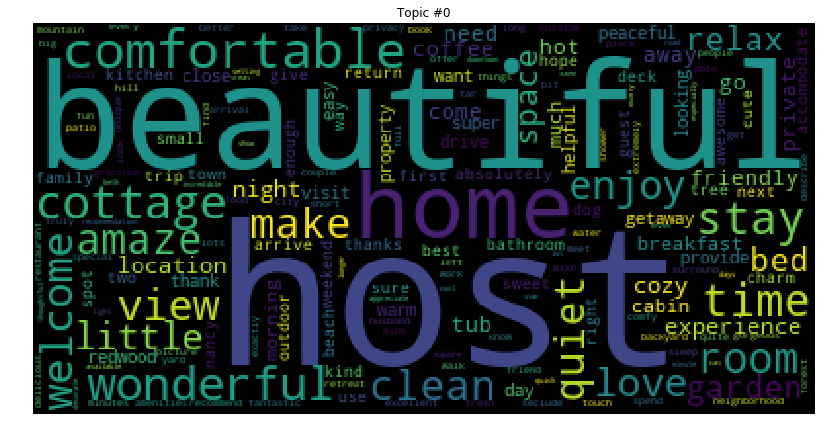

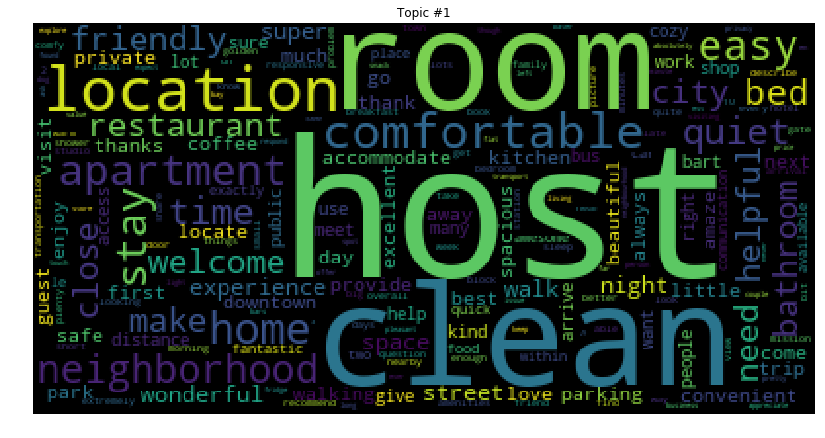

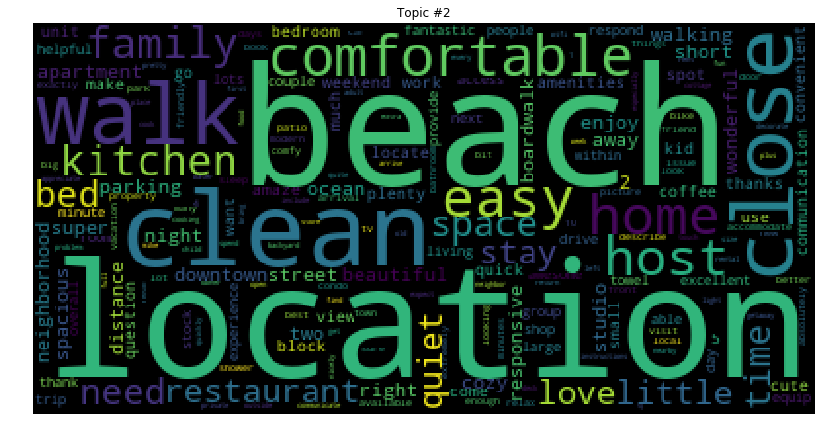

In [85]:
topics_3.word_cloud(num_of_topics=3)

In [72]:
# Find out topic for each individual review

for i in lda_3.get_document_topics(topics_3.corpus):
    print (i)

[(0, 0.7610614), (1, 0.08597191), (2, 0.15296672)]
[(0, 0.20349506), (1, 0.1735559), (2, 0.62294906)]
[(0, 0.61563635), (1, 0.24916852), (2, 0.13519514)]
[(0, 0.6790144), (1, 0.064324126), (2, 0.25666144)]
[(0, 0.9861119), (1, 0.013763581)]
[(0, 0.992153)]
[(0, 0.39289746), (1, 0.15532012), (2, 0.45178244)]
[(0, 0.97705233), (1, 0.021794694)]
[(0, 0.99786407)]
[(0, 0.6746118), (1, 0.13477625), (2, 0.19061194)]
[(0, 0.66482824), (1, 0.053511806), (2, 0.28165996)]
[(0, 0.8221813), (1, 0.08840548), (2, 0.0894132)]
[(0, 0.54388845), (1, 0.13408479), (2, 0.3220267)]
[(0, 0.89745605), (2, 0.10165039)]
[(0, 0.75061274), (2, 0.2448391)]
[(0, 0.5151703), (1, 0.33321768), (2, 0.15161206)]
[(0, 0.5000586), (1, 0.38563207), (2, 0.1143093)]
[(0, 0.85249484), (1, 0.058216777), (2, 0.0892884)]
[(0, 0.80599624), (1, 0.14195147), (2, 0.052052293)]
[(0, 0.9946754)]
[(0, 0.9904654)]
[(0, 0.31374985), (1, 0.46162048), (2, 0.22462963)]
[(0, 0.71464837), (1, 0.27084166), (2, 0.014509966)]
[(0, 0.9920125)]
[

[(0, 0.9588193), (1, 0.0401396)]
[(0, 0.92763555), (1, 0.026698194), (2, 0.045666255)]
[(0, 0.72137713), (2, 0.27723166)]
[(0, 0.9951156)]
[(0, 0.9566933), (1, 0.036616202)]
[(0, 0.98580885)]
[(0, 0.68832093), (1, 0.12707978), (2, 0.18459934)]
[(0, 0.9662798), (1, 0.032595806)]
[(0, 0.83111113), (1, 0.16822816)]
[(0, 0.28832793), (2, 0.7111175)]
[(0, 0.8882199), (1, 0.03428092), (2, 0.07749915)]
[(0, 0.93825644), (2, 0.061242756)]
[(0, 0.6530252), (1, 0.19344282), (2, 0.15353195)]
[(0, 0.82592034), (1, 0.13868213), (2, 0.035397593)]
[(0, 0.7200746), (1, 0.021540066), (2, 0.2583854)]
[(0, 0.9166395), (2, 0.08042781)]
[(0, 0.86047006), (2, 0.1337192)]
[(0, 0.79637), (1, 0.19248231), (2, 0.011147656)]
[(0, 0.320729), (1, 0.109078534), (2, 0.57019246)]
[(0, 0.5162937), (2, 0.48363692)]
[(0, 0.8627814), (1, 0.12982722)]
[(0, 0.99266434)]
[(0, 0.83215237), (1, 0.039643914), (2, 0.12820373)]
[(0, 0.65141034), (2, 0.34851962)]
[(0, 0.93288904), (2, 0.06693763)]
[(0, 0.628469), (2, 0.37146318)]

[(0, 0.56471467), (2, 0.4255615)]
[(0, 0.9905889)]
[(0, 0.694983), (2, 0.30397567)]
[(0, 0.80010986), (2, 0.19350927)]
[(0, 0.9931102)]
[(0, 0.7782522), (1, 0.084291965), (2, 0.13745584)]
[(0, 0.96895516), (1, 0.015889117), (2, 0.015155689)]
[(0, 0.8870595), (1, 0.010531588), (2, 0.10240895)]
[(0, 0.99023026)]
[(0, 0.9604193), (1, 0.032758545)]
[(0, 0.92093235), (1, 0.07597486)]
[(0, 0.78580624), (1, 0.06534916), (2, 0.14884454)]
[(0, 0.46052414), (1, 0.34694842), (2, 0.19252747)]
[(0, 0.9342481), (1, 0.058532134)]
[(0, 0.98363566), (1, 0.015986234)]
[(0, 0.9158027), (2, 0.08192626)]
[(0, 0.6810324), (1, 0.05949432), (2, 0.25947326)]
[(0, 0.8346584), (1, 0.10825035), (2, 0.057091277)]
[(0, 0.2944097), (2, 0.70328283)]
[(0, 0.9946303)]
[(0, 0.6425902), (1, 0.35520667)]
[(0, 0.8841774), (2, 0.11308824)]
[(0, 0.771308), (1, 0.19520496), (2, 0.033487022)]
[(0, 0.8941003), (1, 0.01086772), (2, 0.09503201)]
[(0, 0.7236489), (1, 0.2761945)]
[(0, 0.95975506), (1, 0.030527253)]
[(0, 0.9984554)]

[(0, 0.91878396), (1, 0.01840592), (2, 0.06281011)]
[(0, 0.6510265), (2, 0.3481345)]
[(0, 0.5393328), (1, 0.4511137)]
[(0, 0.414951), (2, 0.583224)]
[(0, 0.91938835), (1, 0.07817578)]
[(0, 0.70396537), (1, 0.020330716), (2, 0.27570397)]
[(0, 0.64922297), (2, 0.34971374)]
[(0, 0.67537963), (2, 0.32221186)]
[(0, 0.9963696)]
[(0, 0.4950762), (2, 0.50460047)]
[(0, 0.926308), (1, 0.037404943), (2, 0.036287084)]
[(0, 0.62687993), (1, 0.29352844), (2, 0.07959155)]
[(0, 0.8576068), (2, 0.13757408)]
[(0, 0.98169583), (1, 0.014819564)]
[(0, 0.6480651), (1, 0.2714768), (2, 0.08045815)]
[(0, 0.95764816), (1, 0.020080036), (2, 0.022271818)]
[(0, 0.7808686), (1, 0.20580228), (2, 0.013329122)]
[(0, 0.9249837), (1, 0.012115676), (2, 0.06290066)]
[(0, 0.86506546), (1, 0.029515462), (2, 0.1054191)]
[(0, 0.96430475), (2, 0.03305522)]
[(0, 0.97042125), (2, 0.024622092)]
[(0, 0.9851002)]
[(0, 0.91049623), (2, 0.084698044)]
[(0, 0.3275345), (2, 0.66783565)]
[(0, 0.9200087), (1, 0.059512258), (2, 0.02047896)

[(2, 0.99102026)]
[(0, 0.94350165), (1, 0.055096846)]
[(0, 0.87141585), (1, 0.021064095), (2, 0.10752003)]
[(0, 0.9897721)]
[(0, 0.68534636), (1, 0.027313065), (2, 0.28734052)]
[(0, 0.48074737), (1, 0.030999409), (2, 0.4882532)]
[(0, 0.02882821), (1, 0.022628512), (2, 0.94854325)]
[(0, 0.9637), (1, 0.033921644)]
[(0, 0.86114556), (1, 0.06672441), (2, 0.07213002)]
[(0, 0.22735277), (1, 0.03714257), (2, 0.7355047)]
[(0, 0.90084434), (1, 0.07816524), (2, 0.020990446)]
[(0, 0.97058463), (1, 0.0145797), (2, 0.01483562)]
[(0, 0.98596394)]
[(0, 0.6297436), (2, 0.36710447)]
[(0, 0.9285466), (2, 0.0680625)]
[(0, 0.9284726), (1, 0.036676284), (2, 0.0348511)]
[(0, 0.98435384)]
[(0, 0.8889787), (1, 0.110656165)]
[(0, 0.7501093), (1, 0.022474572), (2, 0.22741607)]
[(0, 0.2519107), (1, 0.62697977), (2, 0.121109515)]
[(0, 0.98322904)]
[(0, 0.37975284), (1, 0.45584187), (2, 0.16440524)]
[(0, 0.8671687), (2, 0.12761192)]
[(0, 0.96934295), (2, 0.029942188)]
[(0, 0.79732245), (2, 0.20148751)]
[(0, 0.9066

[(0, 0.6138091), (2, 0.38173223)]
[(0, 0.59584254), (2, 0.4025185)]
[(0, 0.39247596), (1, 0.010050793), (2, 0.5974733)]
[(0, 0.46167815), (1, 0.12447601), (2, 0.4138458)]
[(0, 0.34457463), (1, 0.07999403), (2, 0.57543135)]
[(0, 0.67135507), (1, 0.3251234)]
[(0, 0.18263492), (1, 0.07483822), (2, 0.7425269)]
[(0, 0.43542236), (1, 0.29222423), (2, 0.27235338)]
[(0, 0.9619817), (2, 0.03099787)]
[(0, 0.87205464), (1, 0.123871446)]
[(0, 0.18815835), (2, 0.8088787)]
[(0, 0.017666066), (1, 0.037994146), (2, 0.9443398)]
[(0, 0.97931516), (2, 0.01079184)]
[(0, 0.9784325), (1, 0.013484627)]
[(0, 0.44370446), (1, 0.094130844), (2, 0.46216473)]
[(0, 0.98172677)]
[(0, 0.9747003), (2, 0.020516967)]
[(0, 0.98288554)]
[(0, 0.982761), (1, 0.016163325)]
[(0, 0.2899443), (2, 0.7068155)]
[(0, 0.94018275), (1, 0.029510997), (2, 0.030306242)]
[(0, 0.81119806), (2, 0.18777713)]
[(0, 0.69811344), (2, 0.30013254)]
[(0, 0.9950357)]
[(0, 0.72487885), (1, 0.26937702)]
[(0, 0.9348659), (1, 0.03282082), (2, 0.032313

[(0, 0.6480165), (1, 0.18619207), (2, 0.16579142)]
[(0, 0.064205125), (1, 0.3240533), (2, 0.61174154)]
[(0, 0.35809633), (2, 0.6351216)]
[(0, 0.69172156), (1, 0.20496212), (2, 0.10331632)]
[(0, 0.30381778), (1, 0.68350613), (2, 0.012676106)]
[(0, 0.05790683), (2, 0.9377409)]
[(0, 0.9384217), (2, 0.060107637)]
[(0, 0.40626952), (1, 0.5904217)]
[(0, 0.6399819), (1, 0.23232175), (2, 0.12769632)]
[(0, 0.35228613), (2, 0.6465605)]
[(0, 0.5359908), (1, 0.42662787), (2, 0.037381306)]
[(1, 0.010917023), (2, 0.98890704)]
[(0, 0.08709738), (1, 0.52005416), (2, 0.3928485)]
[(0, 0.3011491), (1, 0.21758516), (2, 0.48126575)]
[(0, 0.010012197), (1, 0.38969892), (2, 0.60028887)]
[(0, 0.85365313), (2, 0.14113909)]
[(0, 0.86217815), (1, 0.023292055), (2, 0.114529744)]
[(0, 0.21149443), (1, 0.4489173), (2, 0.33958828)]
[(0, 0.8828659), (2, 0.11502444)]
[(0, 0.99495965)]
[(0, 0.820376), (2, 0.1783513)]
[(2, 0.9825056)]
[(0, 0.62291235), (2, 0.37648007)]
[(0, 0.013910156), (1, 0.013546565), (2, 0.9725433)

[(0, 0.014063184), (1, 0.3512765), (2, 0.6346603)]
[(0, 0.6089427), (1, 0.1539922), (2, 0.23706509)]
[(0, 0.50696975), (1, 0.250078), (2, 0.24295229)]
[(1, 0.1191873), (2, 0.877365)]
[(0, 0.5236819), (2, 0.47144046)]
[(0, 0.651854), (1, 0.016139925), (2, 0.33200613)]
[(0, 0.20954116), (1, 0.16086249), (2, 0.6295964)]
[(0, 0.4073295), (2, 0.59215134)]
[(0, 0.89656585), (1, 0.08932655), (2, 0.014107665)]
[(0, 0.60886675), (1, 0.037968926), (2, 0.35316437)]
[(0, 0.6525721), (2, 0.3466231)]
[(0, 0.23755825), (1, 0.020177899), (2, 0.74226385)]
[(0, 0.25033802), (1, 0.010705793), (2, 0.7389562)]
[(2, 0.99557644)]
[(2, 0.9946192)]
[(0, 0.018198404), (1, 0.5628853), (2, 0.41891634)]
[(0, 0.35673577), (1, 0.04211791), (2, 0.6011463)]
[(0, 0.9085509), (2, 0.086940855)]
[(0, 0.19987367), (2, 0.79778516)]
[(0, 0.48950166), (1, 0.0507823), (2, 0.45971602)]
[(1, 0.042438116), (2, 0.94766307)]
[(0, 0.710692), (1, 0.18153575), (2, 0.107772246)]
[(0, 0.5011939), (1, 0.112201676), (2, 0.38660446)]
[(0, 

[(2, 0.9932334)]
[(2, 0.99364936)]
[(2, 0.9971232)]
[(0, 0.32528153), (2, 0.67414707)]
[(0, 0.5748255), (1, 0.24938016), (2, 0.17579432)]
[(0, 0.135322), (1, 0.01383568), (2, 0.8508423)]
[(1, 0.24721159), (2, 0.7525279)]
[(0, 0.04472732), (1, 0.5587806), (2, 0.39649206)]
[(0, 0.15250644), (2, 0.8462216)]
[(0, 0.3694155), (1, 0.030755475), (2, 0.5998291)]
[(0, 0.41997895), (2, 0.5776631)]
[(0, 0.73326933), (1, 0.1761009), (2, 0.0906298)]
[(0, 0.3857895), (1, 0.010998906), (2, 0.6032116)]
[(0, 0.36241674), (2, 0.62792844)]
[(2, 0.98491544)]
[(0, 0.011985243), (1, 0.01146087), (2, 0.9765539)]
[(0, 0.36518827), (1, 0.08771162), (2, 0.5471001)]
[(0, 0.030769361), (1, 0.015702674), (2, 0.9535279)]
[(0, 0.2693817), (2, 0.73016405)]
[(0, 0.034761757), (2, 0.9649404)]
[(0, 0.36807427), (1, 0.14583473), (2, 0.48609102)]
[(0, 0.318341), (1, 0.10420072), (2, 0.57745826)]
[(0, 0.7072263), (1, 0.08855859), (2, 0.20421518)]
[(0, 0.014838432), (2, 0.98451436)]
[(0, 0.061074708), (2, 0.9380149)]
[(0, 0

[(0, 0.013077306), (1, 0.3105371), (2, 0.67638564)]
[(0, 0.36966196), (1, 0.08044439), (2, 0.5498937)]
[(0, 0.9666255), (1, 0.016109588), (2, 0.017264862)]
[(0, 0.15760656), (1, 0.011711329), (2, 0.8306821)]
[(1, 0.23751332), (2, 0.7619663)]
[(0, 0.64922976), (2, 0.3486923)]
[(0, 0.8845016), (2, 0.10946688)]
[(0, 0.39960515), (2, 0.5954547)]
[(0, 0.7486622), (2, 0.25010118)]
[(0, 0.93460494), (2, 0.06389424)]
[(0, 0.60161805), (1, 0.11856), (2, 0.27982193)]
[(0, 0.48987716), (2, 0.50900495)]
[(2, 0.9942911)]
[(2, 0.99238926)]
[(0, 0.6165888), (1, 0.10299737), (2, 0.28041384)]
[(0, 0.7427337), (1, 0.11050511), (2, 0.1467612)]
[(0, 0.5145203), (1, 0.15920337), (2, 0.3262764)]
[(0, 0.47131607), (2, 0.5225912)]
[(0, 0.49370253), (1, 0.09937325), (2, 0.40692425)]
[(0, 0.564744), (1, 0.09456209), (2, 0.34069386)]
[(0, 0.052802317), (1, 0.060521077), (2, 0.88667655)]
[(0, 0.7773332), (2, 0.22018337)]
[(2, 0.9960005)]
[(0, 0.010239841), (1, 0.010074338), (2, 0.97968584)]
[(2, 0.98735255)]
[(0,

[(0, 0.027484654), (1, 0.02859724), (2, 0.9439181)]
[(2, 0.9892462)]
[(1, 0.06872237), (2, 0.9285751)]
[(0, 0.96186125), (1, 0.015724435), (2, 0.022414321)]
[(1, 0.5177364), (2, 0.47982377)]
[(2, 0.99500257)]
[(2, 0.9860271)]
[(0, 0.69108164), (2, 0.3019723)]
[(0, 0.22623548), (2, 0.7664032)]
[(0, 0.015621451), (2, 0.9805424)]
[(0, 0.6949706), (2, 0.3011808)]
[(0, 0.9607748), (2, 0.03519151)]
[(0, 0.019189384), (2, 0.9720855)]
[(1, 0.44037467), (2, 0.5579826)]
[(2, 0.9926057)]
[(0, 0.42368874), (1, 0.3326073), (2, 0.24370404)]
[(2, 0.99245554)]
[(0, 0.44172576), (2, 0.54846466)]
[(1, 0.60340583), (2, 0.39126164)]
[(2, 0.98244894)]
[(0, 0.23535575), (2, 0.76281416)]
[(0, 0.92195994), (1, 0.0197119), (2, 0.058328163)]
[(0, 0.2550122), (2, 0.74234027)]
[(0, 0.97539365), (1, 0.012124898), (2, 0.0124814715)]
[(0, 0.016952002), (1, 0.71468997), (2, 0.26835808)]
[(0, 0.18563949), (1, 0.3357256), (2, 0.47863483)]
[(0, 0.2770886), (1, 0.057089627), (2, 0.66582173)]
[(0, 0.7872534), (2, 0.207533

[(0, 0.07552632), (1, 0.82973903), (2, 0.094734624)]
[(0, 0.3909411), (1, 0.59605014), (2, 0.01300877)]
[(1, 0.98014927), (2, 0.019652853)]
[(0, 0.3031209), (1, 0.67819643), (2, 0.018682702)]
[(0, 0.010137965), (1, 0.6810129), (2, 0.30884913)]
[(0, 0.102306426), (1, 0.89673674)]
[(0, 0.13168727), (1, 0.8671402)]
[(0, 0.028209275), (1, 0.9688834)]
[(1, 0.91075754), (2, 0.085962184)]
[(0, 0.052428607), (1, 0.94554025)]
[(0, 0.106088094), (1, 0.8894995)]
[(0, 0.6859662), (1, 0.26801187), (2, 0.046022017)]
[(0, 0.073476225), (1, 0.92542493)]
[(0, 0.028416222), (1, 0.9698117)]
[(0, 0.044256292), (1, 0.044271234), (2, 0.91147244)]
[(1, 0.9969899)]
[(0, 0.035449), (1, 0.9627155)]
[(0, 0.047998518), (1, 0.9021805), (2, 0.049821004)]
[(0, 0.07749396), (1, 0.11447411), (2, 0.8080319)]
[(0, 0.46781832), (1, 0.5298929)]
[(1, 0.9931567)]
[(0, 0.14386795), (1, 0.84486634), (2, 0.011265664)]
[(0, 0.042283937), (1, 0.95065993)]
[(0, 0.093879305), (1, 0.82688624), (2, 0.07923448)]
[(1, 0.9951334)]
[(0,

In [63]:
# Identify top 5 topics

topics_5 = TopicModelEngine(X)
lda_5 = topics_5.LDA_model(num_of_topics=5, 
                              num_passes=10,
                              stop_words=total_words_to_exclude)
topics_5.print_topics(num_of_words=10)

Topic 1: 0.013*"studio" + 0.013*"space" + 0.013*"location" + 0.010*"clean" + 0.009*"host" + 0.008*"comfortable" + 0.007*"easy" + 0.007*"little" + 0.007*"home" + 0.007*"time"
Topic 2: 0.023*"host" + 0.020*"home" + 0.015*"room" + 0.012*"comfortable" + 0.012*"welcome" + 0.011*"beautiful" + 0.011*"stay" + 0.010*"wonderful" + 0.009*"time" + 0.009*"make"
Topic 3: 0.033*"beach" + 0.017*"location" + 0.011*"home" + 0.011*"walk" + 0.011*"clean" + 0.009*"comfortable" + 0.009*"family" + 0.008*"close" + 0.008*"host" + 0.008*"time"
Topic 4: 0.021*"clean" + 0.016*"location" + 0.015*"room" + 0.015*"host" + 0.013*"apartment" + 0.011*"comfortable" + 0.010*"easy" + 0.008*"stay" + 0.008*"quiet" + 0.008*"close"
Topic 5: 0.013*"cottage" + 0.013*"host" + 0.011*"beautiful" + 0.009*"comfortable" + 0.009*"quiet" + 0.008*"clean" + 0.008*"wonderful" + 0.008*"time" + 0.007*"stay" + 0.007*"tub"


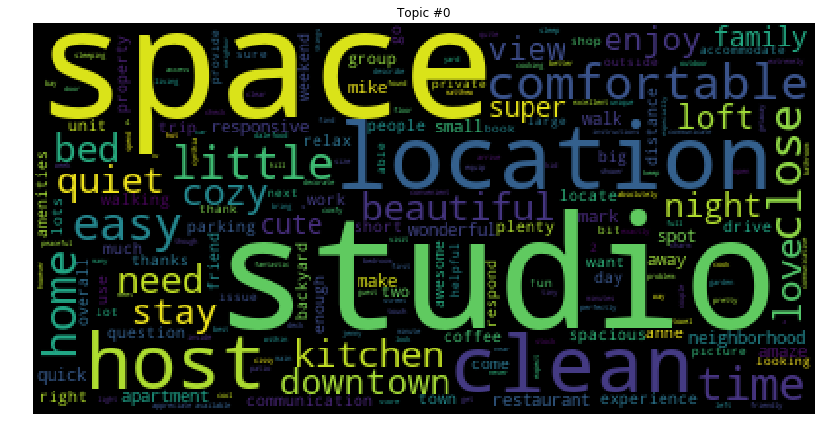

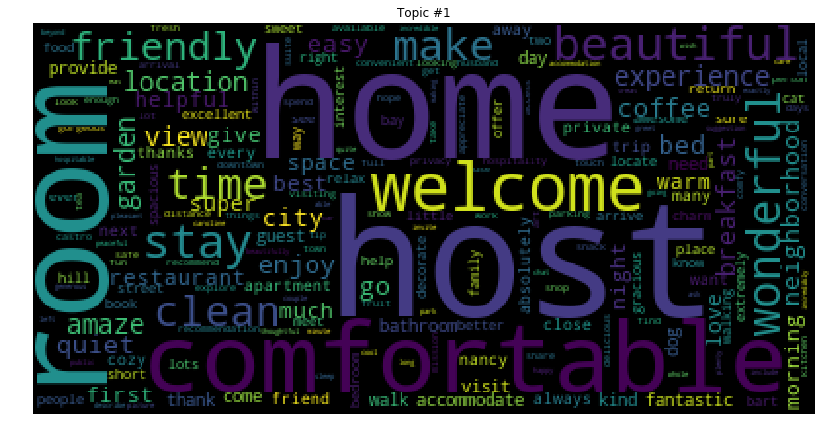

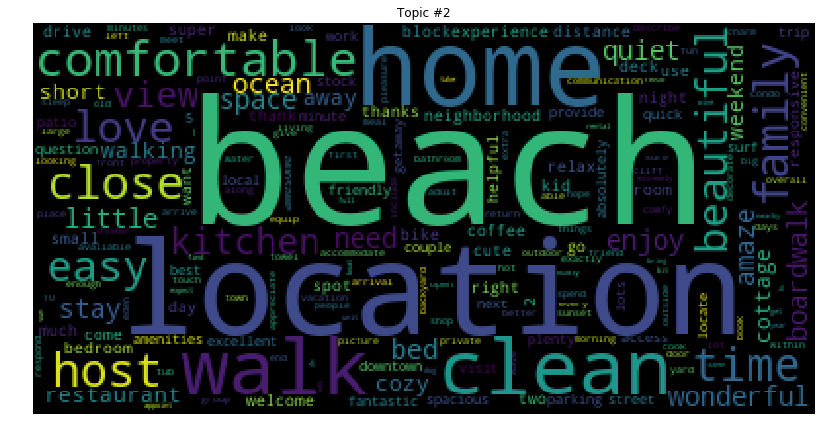

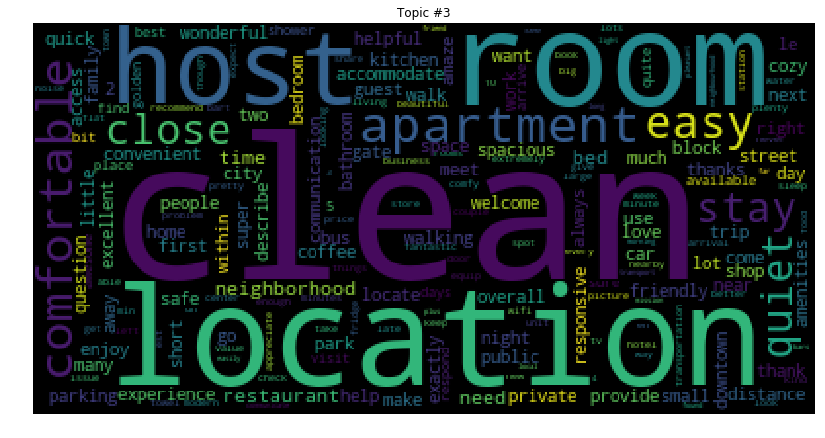

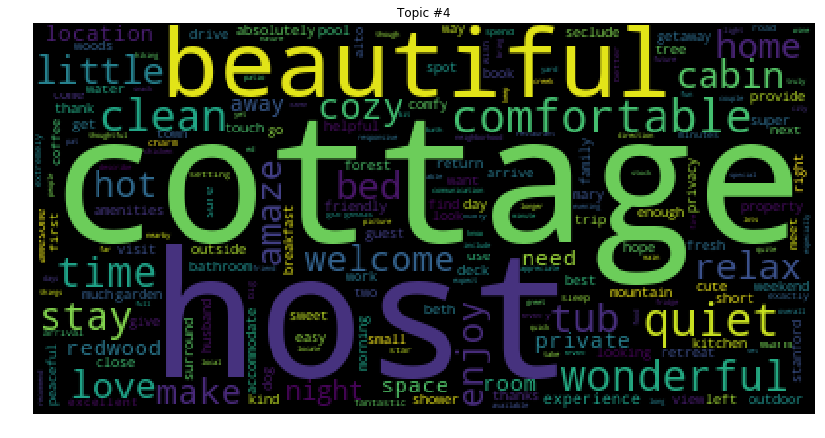

In [64]:
topics_5.word_cloud(num_of_topics=5)

In [65]:
# Identify top 10 topics

topics_10 = TopicModelEngine(X)
lda_10 = topics_10.LDA_model(num_of_topics=10, 
                              num_passes=10,
                              stop_words=total_words_to_exclude)
topics_10.print_topics(num_of_words=10)

Topic 1: 0.023*"clean" + 0.018*"location" + 0.012*"host" + 0.010*"easy" + 0.010*"comfortable" + 0.009*"close" + 0.008*"bed" + 0.008*"need" + 0.007*"parking" + 0.007*"quiet"
Topic 2: 0.043*"room" + 0.022*"clean" + 0.022*"host" + 0.014*"comfortable" + 0.011*"home" + 0.011*"location" + 0.011*"bathroom" + 0.011*"stay" + 0.010*"friendly" + 0.009*"time"
Topic 3: 0.044*"cottage" + 0.015*"clean" + 0.015*"location" + 0.013*"quiet" + 0.013*"comfortable" + 0.011*"little" + 0.010*"host" + 0.009*"walk" + 0.009*"neighborhood" + 0.009*"easy"
Topic 4: 0.018*"apartment" + 0.015*"location" + 0.011*"host" + 0.011*"city" + 0.010*"clean" + 0.009*"restaurant" + 0.009*"neighborhood" + 0.009*"easy" + 0.008*"comfortable" + 0.008*"park"
Topic 5: 0.036*"studio" + 0.015*"space" + 0.013*"cozy" + 0.013*"location" + 0.012*"clean" + 0.012*"comfortable" + 0.011*"little" + 0.011*"host" + 0.010*"loft" + 0.009*"bed"
Topic 6: 0.024*"apartment" + 0.018*"host" + 0.015*"location" + 0.013*"clean" + 0.012*"comfortable" + 0.010

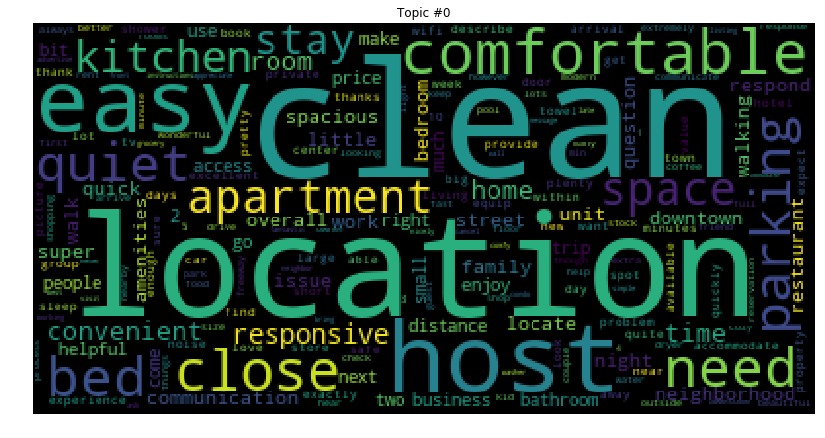

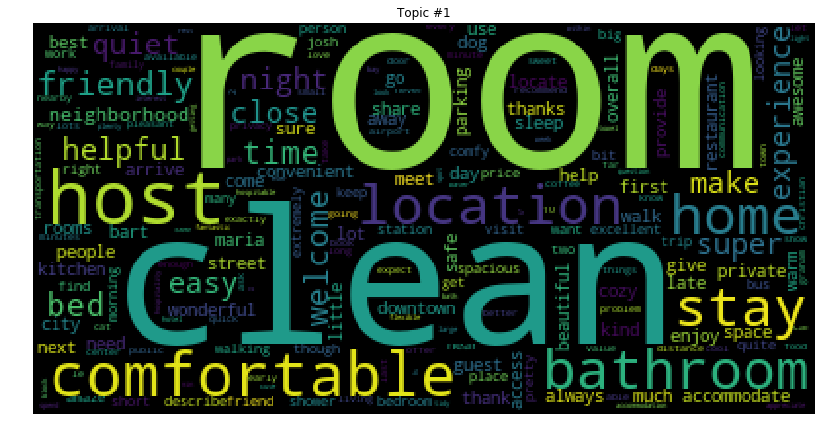

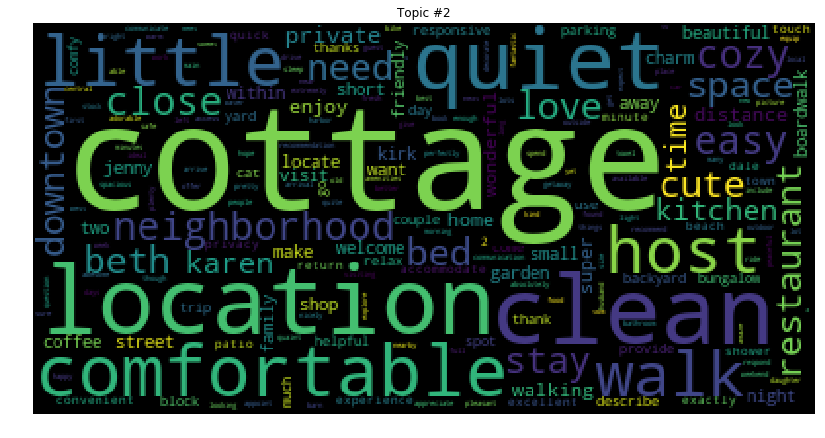

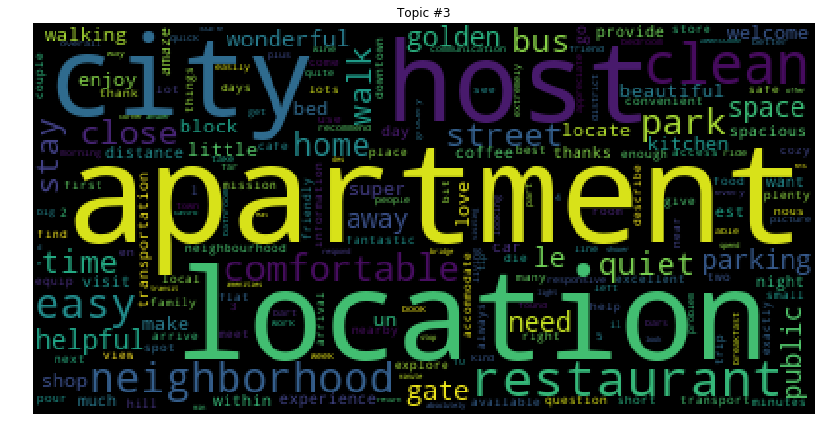

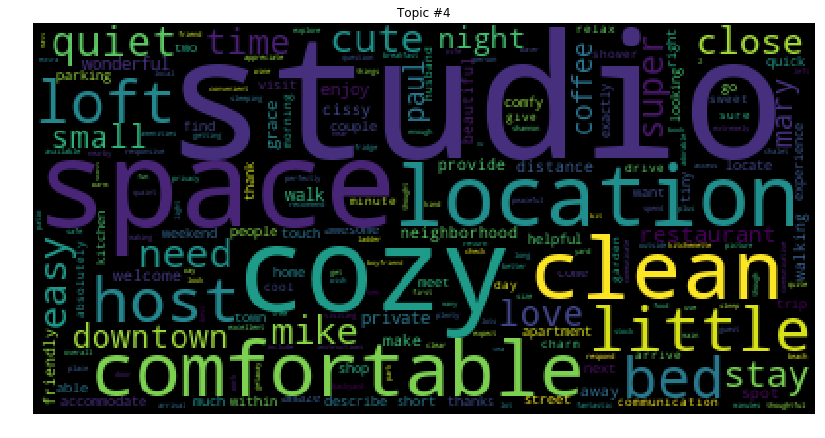

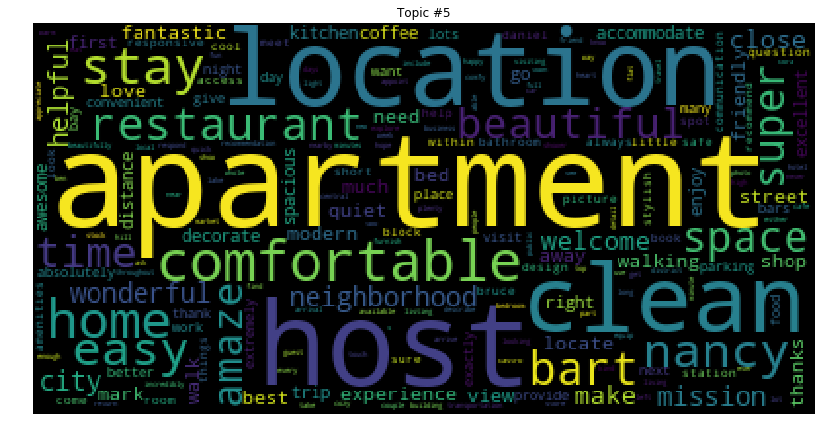

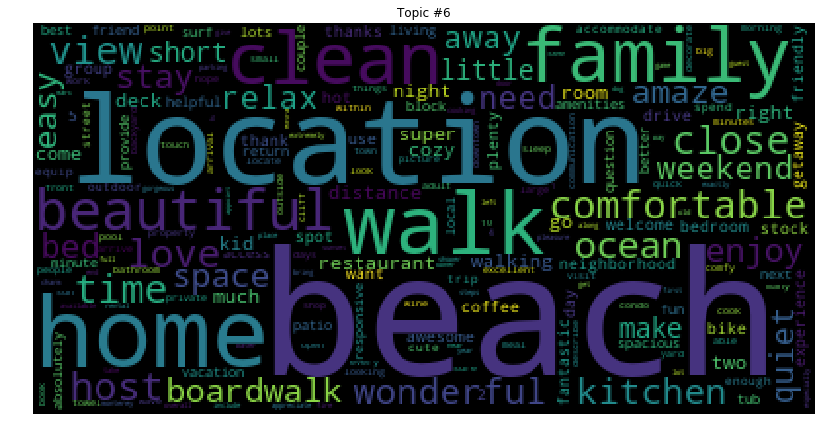

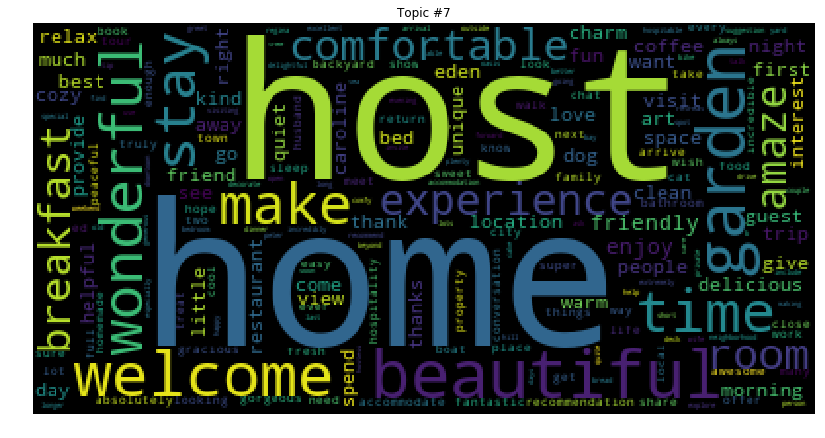

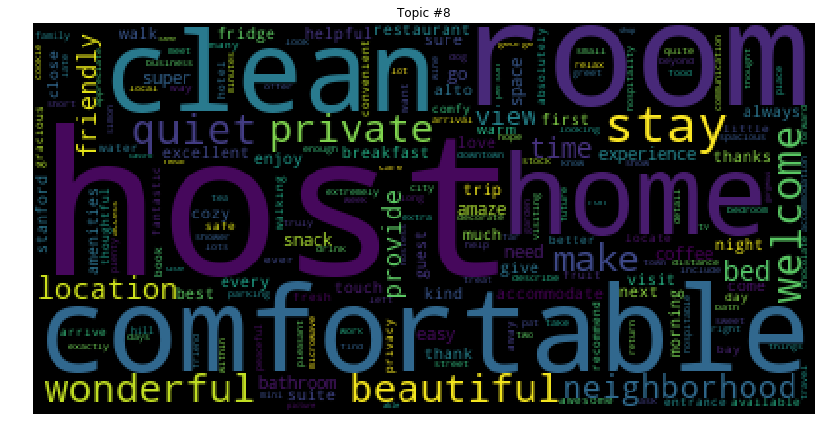

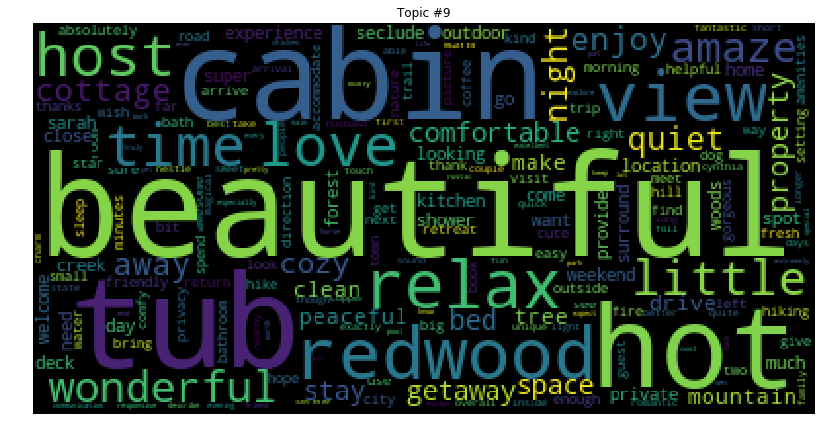

In [66]:
topics_10.word_cloud(num_of_topics=10)